# Grammatical Error Correction

This project is part of the assessment for the course **MLMI3: Probabilistic Automata**, taught by **Prof. Bill Byrne**, in **University of Cambridge**.

This project is based on the following paper

>[Language Model Based Grammatical Error Correction without Annotated Training Data, C Bryant and T Briscoe, 
Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, June 2018.]( https://aclweb.org/anthology/W18-0529)

This notebook aims to provide the explanations on the steps I took in order to complete this project.

----

# Table of Contents

>## 1. Preparation
* **1.1. Necessary Modules**
* **1.2. Data**
* **1.3. Scoring Method**

>## 2. Method
* **2.1. Edit Transducer**
  * 2.1.1. Objective
  * 2.1.2. Code
  * 2.1.3. Example of Usage
* **2.2. LMMap Vocabulary Transducer**
  * 2.2.1. Objective
  * 2.2.2. Code
  * 2.2.3. Example of Usage
* **2.3. N-Gram Language Model**
  * 2.3.1. Objective
  * 2.3.2. Code - Construction of LM
  * 2.3.3. Code - Application of LM
  * 2.3.4. Example of Usage
* **2.4. Edit Penalty**
  * 2.4.1. Objective
  * 2.4.2. Code
  * 2.4.3. Example of Usage
* **2.5. Hypotheses and Evaluation**
  * 2.5.1. Objective
  * 2.5.2. Code
  * 2.5.3. Example of Usage

>## 3. Experiments
* **3.1. Effect of Determinization and Minimization on the Processing Time**
  * 3.1.1. Method
  * 3.1.2. Experiment & Results
  * 3.1.3. Discussion
* **3.2. Oracle Sentence Error Rate**
  * 3.2.1. Method
  * 3.2.2. Experiment & Results
  * 3.3.3. Discussion
* **3.3. Effect of N-Gram Order on GEC Performance**
  * 3.3.1. Method
  * 3.3.2. Experiment
  * 3.3.3. Results
  * 3.3.4. Discussion
* **3.4. Effect of Edit Penalty on GEC Performance**
  * 3.4.1. Method
  * 3.4.2. Experiment
  * 3.4.3. Results
  * 3.4.4. Discussion

>## 4. Extension - Character Neural Language Models
* **4.1. Motivation**
* **4.2. Method**
  * 4.2.1. Word to Character Mappings
  * 4.2.2. Training Data for Chracter-level Neural Language Model
* **4.3. Experiment**
  * 4.3.1. Edit Penalty Tuning
  * 4.3.2. Data Preprocessing
  * 4.3.3. Running the Experiments
* **4.4. Results**

----

# 1. Preparation

## 1.1. Necessary Modules

In [2]:
import os
import sys
sys.path.append('/home/wjb31/src/openfst//openfst-1.6.8/INSTALL_DIR/lib/python2.7/site-packages/')
sys.path.append('/home/wjb31/src/openfst//specializer-1.6.8/')
sys.path.append('/home/wjb31/MLMI/util/python/')
import pywrapfst as fst
import specializer
import math
import string
import utilfst
import kenlm

## 1.2. Data

* **The data files were given in the following directory**

>```
DIR='/home/wjb31/MLMI/MLMI3/practical/lm-gec/'
```

* **4 datasets used in this practical**

>|Dataset|No. of Sentences|Original Set|Correction Set(s)|
|-|-|-|
|`CONLL2013`|1381|`DIR/orig/conll2013.nltk.orig`<br/>|`DIR/cor/conll2013.0.nltk.cor`|
|`CONLL2014`|1312|`DIR/orig/conll2013.nltk.orig`|`DIR/cor/conll2014.0.nltk.cor`<br/>`DIR/cor/conll2014.1.nltk.cor`|
|`JFLEG_DEV`| 754|`DIR/orig/jfleg_dev.nltk.orig`|`DIR/cor/jfleg_dev.0.nltk.cor`<br/>`DIR/cor/jfleg_dev.1.nltk.cor`<br/>`DIR/cor/jfleg_dev.2.nltk.cor`<br/>`DIR/cor/jfleg_dev.3.nltk.cor`|
|`JFLEG_TEST`|747|`DIR/orig/jfleg_test.nltk.orig`|`DIR/cor/jfleg_test.0.nltk.cor`<br/>`DIR/cor/jfleg_test.1.nltk.cor`<br/>`DIR/cor/jfleg_test.2.nltk.cor`<br/>`DIR/cor/jfleg_test.3.nltk.cor`|

* **NOTE:** `CONLL2014.short`

>* Omits overly long segments (333 through 335)
>* In order to re-insert the omitted segments:
>
>```
awk -f $DIR/replace.conll2014.332-335.awk $DIR/orig/conll2014.short.nltk.orig
```

* **Original sentences as FSA**

>* The FSA representations of the sentences were given in `DIR/orig/fsts`
>* In the given FSAs, the words are represented as integers. The corresponding symbol table was given in `DIR/wmap/devtest.wmap`

In [3]:
# root directory for data files provided for this practical
DIR='/home/wjb31/MLMI/MLMI3/practical/lm-gec/'

# symbol table
# the symbols can be looked up using: words_ST.find(t)
words_ST=fst.SymbolTable.read_text(DIR+'wmap/devtest.wmap')

In [21]:
# wordmap is given as following
# <s> & </s>: sentence start & end
# <corr> & </corr>: correction tags
# <unk>: unknown

! head -10 $DIR/wmap/devtest.wmap

<epsilon> 0
</s> 1
<s> 2
<unk> 3
<corr> 4
</corr> 5
`` 6
< 7
= 8
> 9


In [10]:
# inspection of original sentence
with open(DIR+'orig/jfleg_dev.nltk.orig') as f:
    print f.readlines()[0]

So I think we can not live if old people could not find siences and tecnologies and they did not developped . 



In [11]:
# inspection of reference sentences
! head -1q $DIR/cor/jfleg_dev.?.nltk.cor 

So I think we would not be alive if our ancestors did not develop sciences and technologies .
So I think we could not live if older people did not develop science and technologies .
So I think we can not live if old people could not find science and technologies and they did not develop .
So I think we can not live if old people can not find the science and technology that has not been developed .


## 1.3. Scoring Method

* **M2 Format**

>* The corrected sentences were also given in the M2 format (in the directory `DIR/m2`). This format contains the information on **where** and **how** the edits were made. Following is an example.
>```
S In modern digital world , electronic products are widely used in daily lives such as Smart phones , computers and etc .
A 1 1|||M:DET|||the|||REQUIRED|||-NONE-|||0
A 12 13|||R:NOUN:NUM|||life|||REQUIRED|||-NONE-|||0
A 15 16|||R:ORTH|||smart|||REQUIRED|||-NONE-|||0
```

* **M2 Scorer**

>* The M2 scorer, provided in `DIR/m2scorer/m2scorer`, was used to measure the model performance. The M2 scorer compares the hypotheses set to the reference set(s) and returns the precision, recall, and the F-score ($F_{0.5}$). 
>* For example, the following command compares the hypotheses `conll2013.hypotheses.txt` to `DIR/m2/conll2013.auto.nltk.m2`
>
>```
! $DIR/m2scorer/m2scorer $conll2013.hypotheses.txt $DIR/m2/conll2013.auto.nltk.m2 ```

* **Scoring `conll2014` Dataset**

>* As explained earlier, the omitted segments should be re-inserted before evaluation
>
>```
! mkdir -p tmp/
! awk -f $DIR/replace.conll2014.332-335.awk $conll2014.short.hypotheses.txt > conll2014.hypotheses.txt
! $DIR/m2scorer/m2scorer conll2014.hypotheses.txt $DIR/m2/conll2014_2.auto.nltk.m2```

# 2. Method

## 2.1. Edit Transducer

### 2.1.1. Objective

* **Edit Options**

>* Edit options are the word-by-word correction options for each word appearing in the dataset
>* Simple error tags are given in `DIR/editoptions/`
>* Typed error tags are given in `DIR/editoptions.tagged/`
>* The edit transducer is built based on `DIR/editoptions/editoptions.devtest`

In [25]:
cat $DIR/editoptions.tagged/conll2013/1198.txt

Then || <infl> then </infl> || <infl> thens </infl>
there || <infl> theres </infl>
comes || <infl> coming </infl> || <infl> came </infl> || <infl> come </infl>
a || <det> an </det> || <det> the </det>
problem || <infl> problems </infl>
.


* **Edit Transducer**

>* A flower transducer that maps each original word to itself & its tagged corrections (e.g. `Then` to `<corr> thens </corr>`)

* **Objective**

>* The edit transducer can be composed to the original sentence. 
>* The output projection of the resulting FSt would generate possible versions of the corrected sentence. 
>
>$$ \Pi_2(O_n  \circ T_\mbox{edit}) $$ 

### 2.1.2. Code

In [5]:
# read edit options
text_list = open(DIR+'/editoptions/editoptions.devtest').readlines()

# the state number to be assigned to the next new state
state_num = 1

# the transducer is written into a text file
with open('t_edit.txt', 'w') as t_edit:

    # for each word, (7125: total number of the words)
    for i in range(7125):
        
        # exclude the edit tags & only extract the edit options as a list
        text = text_list[i][:-1].replace(' </corr>','').split(' || <corr> ')
        # the first element, text[0], is the original word
        # and the following elements are the edit options

        # map the word to itself 
        t_edit.write("0 0 {0} {0}\n".format(words_ST.find(text[0])))
        
        # map the word to its edit options
        if len(text) > 1:
            
            # for each edit option,
            for i in range(1,len(text)):
                
                # split the edit option into words
                # if the edit option consists of one word, text_ will be a list with one element
                text_ = text[i].split(' ')
                
                # map the original word to the correction-start tag, <corr>
                t_edit.write("0 {0} {1} 4\n".format(state_num, words_ST.find(text[0])))

                # map an epsilon to the words in the edit option
                for j in range(0,len(text_)):                    
                    t_edit.write("{0} {1} 0 {2}\n".format(state_num+j, state_num+j+1, words_ST.find(text_[j])))
                
                # map an epsilon to the correction-end tag, </corr>
                t_edit.write("{0} 0 0 5\n".format(state_num+len(text_)))
                
                # update the state number
                state_num += (1+len(text_))

    # specify the final state
    t_edit.write("0")

In [4]:
# read the generated text file as FST
compiler = fst.Compiler()
file = open('t_edit.txt')
for line in file:
    compiler.write(line)
file.close()

tedit = compiler.compile()

### 2.1.3. Example of Usage

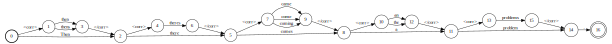

In [35]:
conll2013_1198 = fst.Fst.read(DIR+'orig/fsts/conll2013/1198.fst')
edited_conll2013_1198 = fst.compose(conll2013_1198, tedit)
edited_conll2013_1198.project(project_output=True).set_input_symbols(words_ST)
fst.determinize(edited_conll2013_1198.project(project_output=True)).minimize().set_input_symbols(words_ST)

## 2.2. LMMap Vocabulary Transducer

### 2.2.1. Objective

* **LMMap Vocabulary Transducer**

>* A transducer that:
>  * keeps `<s>`, `</s>`, `<unk>`
>  * deletes `<corr>`, `</corr>` (map to `<epsilon>`)
>  * maps each word in the dataset vocabulary (`DIR/wmaps/devtest.wmap`)
>    * to itself if it is in the LM vocabulary `DIR/BWC/1b.wlist`
>    * to `<unk>` if not

* **Objective**

>* The LMMap transducer can be composed to the possible candidates, to make sure that the candidates consist of the words in the LM vocabulary.
>* Then, the language model automata can be applied to yield the sentence probability.
>
>$$ \Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} $$ 

### 2.2.2. Code

In [128]:
# vocabulary of dataset
wmap_list = open(DIR+'wmap/devtest.wmap').readlines()

# vocabulary of the language model
w_list = open(DIR+'BWC/1b.wlist').readlines()

# the transducer is written into a text file
with open('LMmap.txt', 'w') as LMmap:

    # for each word in the dataset vocabulary,
    for i in range(len(wmap_list)):
        
        # only extract the word (not its integer symbol)
        word = wmap_list[i].split('\n')[0].split(' ')[0]
        
        # map the following tags to itself
        if word in ['<epsilon>','<s>','</s>','<unk>']:
            LMmap.write("0 0 {0} {0}\n".format(words_ST.find(word)))
        
        # delete the correction tags
        elif word in ['<corr>','</corr>']:
            LMmap.write("0 0 {0} 0\n".format(words_ST.find(word)))
        
        # if the word is in the LM vocabulary, map the word to itself
        elif word + '\n' in w_list:
            LMmap.write("0 0 {0} {0}\n".format(words_ST.find(word)))
            
        # if not, map the word to <unk>
        elif word != '':
            LMmap.write("0 0 {0} 3\n".format(words_ST.find(word)))
    
    # specify the final state
    LMmap.write("0")

In [9]:
# read the generated text file as FST
del compiler
compiler = fst.Compiler()
file = open('LMmap.txt')
for line in file:
    compiler.write(line)
file.close()

LMmap = compiler.compile()

### 2.2.3. Example of Usage

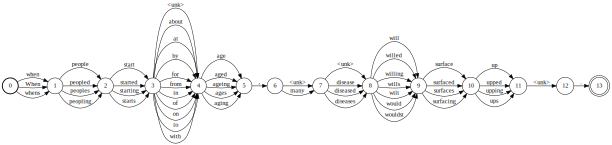

In [132]:
conll2013_0736 = fst.Fst.read(DIR+'orig/fsts/conll2013/0736.fst')
edited_conll2013_0736 = fst.compose(conll2013_0736, tedit).project(project_output=True);
tmp = fst.compose(edited_conll2013_0736, LMmap).project(project_output=True)
fst.determinize(tmp.set_input_symbols(words_ST).rmepsilon()).minimize()

## 2.3. N-Gram Language Model

### 2.3.1. Objective

* **Probabilistic Approach in GEC**

>* A sentence with **less probability** is **more likely to contain grammatical errors**.
>* This project uses the **n-gram probability** trained with the **Billion Word Corpus** data.

* **1 Billion Word Corpus**

In [37]:
! head -2 $DIR/BWC/1b.txt

The U.S. Centers for Disease Control and Prevention initially advised school systems to close if outbreaks occurred , then reversed itself , saying the apparent mildness of the virus meant most schools and day care centers should stay open , even if they had confirmed cases of swine flu .
When Ms. Winfrey invited Suzanne Somers to share her controversial views about bio-identical hormone treatment on her syndicated show in 2009 , it won Ms. Winfrey a rare dollop of unflattering press , including a Newsweek cover story titled " Crazy Talk : Oprah , Wacky Cures & You . "


* **Objective**

>* The n-gram automata can be applied to the candidates to assign sentence probability, based on which the candidates can be compared.
>
>$$ \Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} \circ G_\mbox{2}$$ 

### 2.3.2. Code - Construction of LM
* **NOTE:** the codes in this section are not my original work, and were pre-given by Prof. Byrne.
* **NOTE:** Completion of the following set of commands would require significantly heavy computational cost. Hence, the n-gram WFSAs were pre-given. The path for the WFSA is `DIR/BWC/1b.oX.devtest.fst`, where `X` should be replaced with the n-gram order. These WFSAs, uses $\phi$ failure arcs to implement backoff.

* **Step 1.** Build the 1b 5-gram LM in ARPA format:
  * Following command requires [KenLM Toolkit](http://kheafield.com/code/kenlm/). 
  * Thie command generates the language model `1b.o5.arpa` in ARPA format.

In [38]:
! mkdir -p tmp/
! /homes/wjb31/src/kenlm/build/bin/lmplz -o 5 -S 50% -T tmp/ < $DIR/BWC/1b.txt > 1b.o5.arpa`

In [39]:
! head -20 $DIR/BWC/1b.o5.arpa

\data\
ngram 1=2425340
ngram 2=42806073
ngram 3=192311262
ngram 4=386644600
ngram 5=514998902

\1-grams:
-7.6736765	<unk>	0
0	<s>	-1.9532093
-2.9462602	</s>	0
-3.5282292	The	-0.37614685
-3.6051934	U.S.	-0.8002914
-5.0045657	Centers	-0.67226076
-2.5680723	for	-1.1808379
-5.2290998	Disease	-0.47603542
-4.7897806	Control	-0.4883653
-2.1554835	and	-1.2592585
-5.232552	Prevention	-0.40170538
-3.9288523	initially	-0.7271216


* **Step 2.** Extract only the N-Grams for these  tasks
  * `1b.o5.arpa` contains probabilities for all the 5-grams found in BWC.
  * `DIR/wmap/devtest.vbs` contains the target vocabularies for the corrections
  * The following step filters out n-grams that cannot be formed from words on the same line in the `devtest.vbs` file:  

In [40]:
! cat $DIR/wmap/devtest.vbs | /homes/wjb31/src/kenlm/build/bin/filter union 1b.o5.arpa 1b.o5.devtest.arpa                                

* **Step 3.** N-Gram LMs as WFSAs
  * Use the [OpenGRM NGram Library](http://www.opengrm.org/twiki/bin/view/GRM/NGramLibrary) to convert ARPA files to WFSAs.

In [41]:
# Note that the `grep` and `sed` are only to ensure that the ARPA text file 
# has one single blank line preceeding each \n-gram identifier.
! grep . $DIR/BWC/1b.o5.devtest.arpa | sed 's,^\\,\n\\,' |\
/homes/wjb31/src/openfst/opengrm-ngram-1.3.4/INSTALL_DIR/bin/ngramread \
--symbols=$DIR/wmap/devtest.wmap --ARPA - 1b.o5.devtest.fst 

* **Result:** N-gram automata of different order
   * `DIR/BWC/1b.o6.devtest.fst`
   * `DIR/BWC/1b.o5.devtest.fst`
   * `DIR/BWC/1b.o4.devtest.fst`
   * `DIR/BWC/1b.o3.devtest.fst`
   * `DIR/BWC/1b.o2.devtest.fst`
   * `DIR/BWC/1b.o1.devtest.fst`   

In [11]:
G_o1 = specializer.phi(fst.Fst.read(DIR+'BWC/1b.o1.devtest.fst'), -2, "never", True).get() 
G_o2 = specializer.phi(fst.Fst.read(DIR+'BWC/1b.o2.devtest.fst'), -2, "never", True).get() 
G_o3 = specializer.phi(fst.Fst.read(DIR+'BWC/1b.o3.devtest.fst'), -2, "never", True).get()
G_o4 = specializer.phi(fst.Fst.read(DIR+'BWC/1b.o4.devtest.fst'), -2, "never", True).get()
G_o5 = specializer.phi(fst.Fst.read(DIR+'BWC/1b.o5.devtest.fst'), -2, "never", True).get()

### 2.3.3. Code - Application of LM

In [30]:
#############
# CONLL2013 #
#############

! mkdir -p EditAcceptors.1gLM/conll2013/
! mkdir -p EditAcceptors.2gLM/conll2013/
! mkdir -p EditAcceptors.3gLM/conll2013/
! mkdir -p EditAcceptors.4gLM/conll2013/
! mkdir -p EditAcceptors.5gLM/conll2013/

# list of n-gram language model
LM_list = [G_o1, G_o2, G_o3, G_o4, G_o5]

idx = 0
while True:
    idx += 1

    # for each original sentence (given as FST),
    srcfile = DIR+'orig/fsts/conll2013/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    src = fst.Fst.read(srcfile)
    
    # create a new FST by composing it with the edit transducer and the LMMap transducer    
    fst_ = fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap)
    
    # apply the n-gram language model for n = 1,2,3,4,5
    # save the resulting FST in appropriate directory
    for i in range(0,5):
        tgt = 'EditAcceptors.{0}gLM/conll2013/%04d.fst'.format(i+1)
        tgt = tgt % idx
        if (not os.path.isfile(tgt)):
            tmp = fst.compose(fst_, LM_list[i])
            tmp.write(tgt)

In [26]:
#############
# CONLL2014 #
#############

! mkdir -p EditAcceptors.1gLM/conll2014.short/
! mkdir -p EditAcceptors.2gLM/conll2014.short/
! mkdir -p EditAcceptors.3gLM/conll2014.short/
! mkdir -p EditAcceptors.4gLM/conll2014.short/
! mkdir -p EditAcceptors.5gLM/conll2014.short/

idx = 0
while True:
    idx += 1
    srcfile = DIR+'orig/fsts/conll2014.short/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    src = fst.Fst.read(srcfile)
    fst_ = fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap)
    for i in range(0,5):
        tgt = 'EditAcceptors.{0}gLM/conll2014.short/%04d.fst'.format(i+1)
        tgt = tgt % idx
        if (not os.path.isfile(tgt)):
            tmp = fst.compose(fst_, LM_list[i])
            tmp.write(tgt)

In [27]:
#############
# JFLEG_DEV #
#############

! mkdir -p EditAcceptors.1gLM/jfleg_dev/
! mkdir -p EditAcceptors.2gLM/jfleg_dev/
! mkdir -p EditAcceptors.3gLM/jfleg_dev/
! mkdir -p EditAcceptors.4gLM/jfleg_dev/
! mkdir -p EditAcceptors.5gLM/jfleg_dev/

idx = 0
while True:
    idx += 1
    srcfile = DIR+'orig/fsts/jfleg_dev/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    src = fst.Fst.read(srcfile)    
    fst_ = fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap)
    for i in range(0,5):
        tgt = 'EditAcceptors.{0}gLM/jfleg_dev/%04d.fst'.format(i+1)
        tgt = tgt % idx
        if (not os.path.isfile(tgt)):
            tmp = fst.compose(fst_, LM_list[i])
            tmp.write(tgt)

In [28]:
##############
# JFLEG_TEST #
##############

! mkdir -p EditAcceptors.1gLM/jfleg_test/
! mkdir -p EditAcceptors.2gLM/jfleg_test/
! mkdir -p EditAcceptors.3gLM/jfleg_test/
! mkdir -p EditAcceptors.4gLM/jfleg_test/
! mkdir -p EditAcceptors.5gLM/jfleg_test/

idx = 0
while True:
    idx += 1
    srcfile = DIR+'orig/fsts/jfleg_test/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    src = fst.Fst.read(srcfile)
    fst_ = fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap)
    for i in range(0,5):
        tgt = 'EditAcceptors.{0}gLM/jfleg_test/%04d.fst'.format(i+1)
        tgt = tgt % idx
        if (not os.path.isfile(tgt)):
            tmp = fst.compose(fst_, LM_list[i])
            tmp.write(tgt)

### 2.3.4. Example of Usage
* Since the probability assigned to a word is dependent on the previous word, the sausage structure is lost.

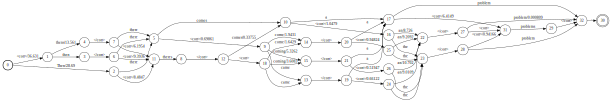

In [134]:
edited_conll2013_1198_LMmap_G2 = fst.Fst.read('EditAcceptors.2gLM/conll2013/1198.fst')
edited_conll2013_1198_LMmap_G2.project()
fst.determinize(edited_conll2013_1198_LMmap_G.rmepsilon()).minimize().set_input_symbols(words_ST)

* The best hypothesis can be extracted as following.
* By pushing the weights to the final state, the path-level score can be examined.

In [135]:
tmp = fst.shortestpath(edited_conll2013_1198_LMmap_G2).rmepsilon().push(to_final=True).topsort()
print tmp.set_input_symbols(words_ST).set_output_symbols(words_ST)

0	1	Then	Then
1	2	there	there
2	3	comes	comes
3	4	a	a
4	5	problem	problem
5	6	.	.
6	28.6896



## 2.4. Edit Penalty

### 2.4.1. Objective

* **Edit Penalty**

>* Edit penalty is added to each edit made in the hypothesis.
>* If the edit penalty is high, the model would not make edit unless it can bring above-threshold probability increase. This would generally result in the increase in precision and decrease in recall. Hence the edit penalty can be tuned to maximise the F-score.

* **Objective**

>* Create a WFSA $A_\lambda$ that assigns edit penalty.
>* Then, the final score of a path can be evaluated under the following FST.
>
>$$ W_{n} = A_\lambda \circ \Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} \circ G_\mbox{2}$$ 

### 2.4.2. Code

In [57]:
def mkcostfst(cost):
    compiler = fst.Compiler(isymbols=words_ST, keep_isymbols=True, osymbols=words_ST, keep_osymbols=True, acceptor=True)
    print >> compiler, "0 0 <corr> " + str(cost)
    print >> compiler, "0 0 <phi> " + str(0.0)
    print >> compiler, "0"
    corr_cost = compiler.compile().arcsort()
    corr_cost = specializer.phi(corr_cost, words_ST.find("<phi>"), "always", True).get()
    return corr_cost

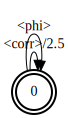

In [58]:
mkcostfst(2.5)

### 2.4.3. Example of Usage

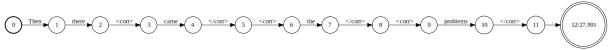

In [59]:
final_conll2013_1198 = fst.shortestpath(fst.compose(mkcostfst(-1.0),edited_conll2013_1198_LMmap_G2))
final_conll2013_1198.rmepsilon().push(to_final=True).topsort().set_input_symbols(words_ST)

## 2.5. Hypotheses and Evaluation

To prepare the output for scoring, it is necessary to remove the correction tags, and also to make a few systematic fixes to problems that might occur:

- if `i` occurs alone, it is captialized to `I`
- the first character of the first word is capitalized

The following brief script will do this:

### 2.5.1. Objective

* **Detokenizer**

>* The string generated by the WFST $ W_{n} = A_\lambda \circ \Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} \circ G_\mbox{2}$ contains tags and is not capitalized.
>* The detokenizer does the following:
>  * Remove `<epsilon>`, `<corr>`, `</corr>`, `<s>`, `</s>`, `<unk>`, `<phi>`.
>  * Capitalize the first character of the first word.
>  * Capitalize the letter `i` if it occurs alone.

* **Objective**

>* The transducer $\Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} \circ G_\mbox{2}$ has been obtained for every combination of **dataset** and **n-gram order**.
>* Arbitrary **edit penalty** can be applied to this WFST.
>* The string represented by the **shortest path** (path with minimal cost) is chosen as the **hypothesis** for that sentence.
>* **Detokenize** each hypothesis.
>* The set of resulting hypotheses is saved as **text file**, and is used to evaluate the **model performance**.
>* The edit penalty is tuned to maximise the performance

### 2.5.2. Code

In [71]:
# detokenizer
def mktok(rawhyp):
    nomap = ['<epsilon>', '<corr>', '</corr>', '<s>', '</s>', '<unk>', '<phi>']
    words = rawhyp.lstrip().split()
    words = [w for w in words if w not in nomap]
    words[0] = words[0].capitalize()
    words = [x if x != 'i' else 'I' for x in words]
    return ' '.join(words)+'\n'

### 2.5.3. Example of Usage
* Example for **CONLL2013**, **2-Gram LM**, and $\lambda = 2.5$

In [137]:
# prepare a list to store hypotheses
conll2013hyps = []

idx = 0
while True:
    
    # for each FST made with CONLL2013 dataset using 2-gram LM,
    idx += 1 
    srcfile = 'EditAcceptors.2gLM/conll2013/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    
    # apply edit penalty of 2.5
    eofst = fst.Fst.read(srcfile)
    tmp = fst.compose(mkcostfst(2.5), eofst)
    
    # add the shortest path to the list
    conll2013hyps.append(utilfst.printstrings(tmp, syms=words_ST)[0] )

In [138]:
! mkdir -p tmp/

# write the hypotheses into text file with suitable name
f = open("tmp/conll2013_Go2_2.5.txt", "w")
for l in conll2013hyps:
    f.write(mktok(l))
f.close()

* **NOTE:** In case of CONLL2014 dataset, the omitted segments must be re-inserted as following.

```
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014_short_Go2_2.5.txt > tmp/conll2014_Go2_2.5.txt```

In [139]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go2_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3206
Recall      : 0.0914
F_0.5       : 0.2135


# 3. Experiments

In [13]:
# this function runs experiment for the given combination of dataset, LM and edit penalty
def run_experiment(dataset, LM, pen, file_name):

    # this may take a few minutes
    hyps = []
    idx = 0
    while True:
        idx += 1 
        srcfile = 'EditAcceptors.{0}gLM/{1}/%04d.fst'.format(LM, dataset)
        srcfile = srcfile % idx
        if (not os.path.isfile(srcfile)):
            break
        eofst = fst.Fst.read(srcfile)
        tmp = fst.compose(mkcostfst(pen), eofst)
        hyps.append(utilfst.printstrings(tmp, syms=words_ST)[0] )

    f = open("tmp/{0}.txt".format(file_name), "w")
    for l in hyps:
        f.write(mktok(l))
    f.close()

## 3.1. Effect of Determinization and Minimization on the Processing Time

### 3.1.1. Method

* The final automata is given as following.

\begin{align}
W_{n} &= A_\lambda \circ E_{n} \\
&= A_\lambda \circ \Pi_2(O_n  \circ T_\mbox{edit}) \circ T_\mbox{LMmap} \circ G_\mbox{2}
\end{align}

* Applying determinization and minimization on $E_n$ simplifies the WFST and thereby accelerates the shortest path operation. Measure the change in processing time to determine the feasibility of such modification.

### 3.1.2. Experiment & Results

* The experiment uses the first 500 sentences in the CONLL2013 dataset.

In [18]:
# time spent to create E_n / without determinization and minimization 

%%time

! mkdir -p EditAcceptors.2gLM/conll2013_exp1/

idx = 0
while True:
    idx += 1
    srcfile = DIR+'orig/fsts/conll2013/%04d.fst' % idx
    if idx == 501:
        break
        
    tgt = 'EditAcceptors.2gLM/conll2013_exp1/%04d.fst' % idx
    if (not os.path.isfile(tgt)):
        src = fst.Fst.read(srcfile)
        tmp = fst.compose(fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap), G_o2)
        tmp.write(tgt)

CPU times: user 8.76 s, sys: 234 ms, total: 9 s
Wall time: 34.2 s


In [22]:
# time spent to create E_n / with determinization and minimization

%%time

! mkdir -p EditAcceptors.2gLM/conll2013_exp2/

idx = 0
while True:
    idx += 1
    srcfile = DIR+'orig/fsts/conll2013/%04d.fst' % idx
    if idx == 501:
        break
        
    tgt = 'EditAcceptors.2gLM/conll2013_exp2/%04d.fst' % idx
    if (not os.path.isfile(tgt)):
        src = fst.Fst.read(srcfile)
        tmp = fst.compose(fst.compose(fst.compose(src,tedit).project(project_output=True), LMmap), G_o2)
        tmp2 = fst.determinize(tmp).minimize()
        tmp2.write(tgt)

CPU times: user 1min 28s, sys: 400 ms, total: 1min 29s
Wall time: 1min 58s


In [20]:
# time spent for shortest path operation - without determinization and minimization

%%time

dataset = 'conll2013_exp1'
LM = 2
pen = 2.5
file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen)

run_experiment(dataset, LM, pen, file_name)

CPU times: user 15.8 s, sys: 104 ms, total: 15.9 s
Wall time: 39.5 s


In [21]:
# time spent for shortest path operation - with determinization and minimization

%%time

dataset = 'conll2013_exp2'
LM = 2
pen = 2.5
file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen)

run_experiment(dataset, LM, pen, file_name)

CPU times: user 8.44 s, sys: 120 ms, total: 8.56 s
Wall time: 26.1 s


### 3.1.3 Discussion

The processing time for GEC operation is reduced by 7.36 seconds, while that for the FST construction is increased by 80 seconds. In this case, the modified procedure would be preferable if more than 10 GEC operations are run for the same set of FSTs.

## 3.2. Oracle Sentence Error Rate

### 3.2.1. Method

* **Oracle Sentence Error Rate** measures how often the search space defined by the edit transducer fails to include at least one of the references.

* For the `JFLEG_DEV` dataset, measure the Oracle Sentence Error Rate by changing the number of reference sets.

### 3.2.2. Experiment & Results

In [30]:
idx = 0

# number of failures
oser0 = 0.0
oser1 = 0.0
oser2 = 0.0
oser3 = 0.0

# total number of sentences
total_num = 0.0

while True:
    idx += 1 
    srcfile = 'EditAcceptors.1gLM/jfleg_dev/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        total_num = idx - 1
        break

    # search space defined by the edit transducer
    c = fst.Fst.read('EditAcceptors.1gLM/jfleg_dev/%04d.fst' % idx).project(project_output=True)
    
    # four reference sets
    r0 = fst.Fst.read(DIR+'cor/fsts/jfleg_dev/%04d.0.fst' % idx)
    r1 = fst.Fst.read(DIR+'cor/fsts/jfleg_dev/%04d.1.fst' % idx)
    r2 = fst.Fst.read(DIR+'cor/fsts/jfleg_dev/%04d.2.fst' % idx)
    r3 = fst.Fst.read(DIR+'cor/fsts/jfleg_dev/%04d.3.fst' % idx)

    # R1: union of r0, r1
    R1 = r0.copy().union(r1).arcsort()
    
    # R2: union of r0, r1, r2
    R2 = r0.copy().union(r1).union(r2).arcsort()
    
    # R3: union of r0, r1, r2, r3
    R3 = r0.copy().union(r1).union(r2).union(r3).arcsort()

    # if r0 is included, no need to check for R1, R2, R3
    # if r0 is not included, check for R1 
    if fst.intersect(c,r0).num_states() == 0:
        oser0 += 1
        if fst.intersect(c,R1).num_states() == 0:
            oser1 += 1
            if fst.intersect(c,R2).num_states() == 0:
                oser2 += 1
                if fst.intersect(c,R3).num_states() == 0:
                    oser3 += 1

# print the Oracle Sentence Error Rate
print(oser0/total_num, oser1/total_num, oser2/total_num, oser3/total_num)

(0.8368700265251989, 0.7785145888594165, 0.7175066312997348, 0.6392572944297082)


### 3.2.3. Discussion

The Oracle error rate is proportional to the number of sentences that have no reference allowed by the edit transducer. Therefore, the error rate is guaranteed to decrease (or at least stay the same) as more reference sets are allowed. Such tendency can be confirmed from the obtained results.

**The effect of increasing the number of references on the GEC performance:**

The m2 scorer evaluates the score of each sentence against every available correction. Then, it uses the set of corrections that maximizes the model performance (i.e. F-score). Therefore, the performance is guaranteed to improve (or stay the same) when more references are given.

For a given grammatically incorrect sentence, there can be multiple ways to modify it. However, some of these correct answers may not be covered by the edit transducer. In order for a GEC model to work properly, its search space must contain at least one correct answer for each given sentence. Therefore, the performance improvement caused by the increase in the number of reference sets is valid, and can be trusted.

## 3.3. Effect of N-Gram Order on GEC Performance

### 3.3.1. Method

* Fix the edit penalty to $2.5$ for the `CONLL` sets and $6.0$ for the `JFLEG` sets
* Measure the GEC performance for different n-gram order  - $1,2,3,4,5$

### 3.3.2. Experiment

In [35]:
dataset = 'conll2013'
LM = [1,2,3,4]
pen = 2.5

for i in range(4):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM[i], pen)
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

conll2013_Go1_2.5
conll2013_Go2_2.5
conll2013_Go3_2.5
conll2013_Go4_2.5


In [39]:
dataset = 'conll2014.short'
LM = [1,2,3,4]
pen = 2.5

for i in range(4):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM[i], pen)
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

conll2014.short_Go1_2.5
conll2014.short_Go2_2.5
conll2014.short_Go3_2.5
conll2014.short_Go4_2.5


In [37]:
dataset = 'jfleg_dev'
LM = [1,2,3,4]
pen = 6.0

for i in range(4):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM[i], pen)
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

jfleg_dev_Go1_6.0
jfleg_dev_Go2_6.0
jfleg_dev_Go3_6.0
jfleg_dev_Go4_6.0


In [38]:
dataset = 'jfleg_test'
LM = [1,2,3,4]
pen = 6.0

for i in range(4):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM[i], pen)
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

jfleg_test_Go1_6.0
jfleg_test_Go2_6.0
jfleg_test_Go3_6.0
jfleg_test_Go4_6.0


### 3.3.3. Results
* `CONLL2013`

In [33]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go1_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.2394
Recall      : 0.0414
F_0.5       : 0.1224


In [35]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go2_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3309
Recall      : 0.0922
F_0.5       : 0.2181


In [37]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3328
Recall      : 0.1304
F_0.5       : 0.2540


In [39]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go4_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3252
Recall      : 0.1340
F_0.5       : 0.2530


* `CONLL2014`

In [48]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go1_2.5.txt > tmp/conll2014_Go1_2.5.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go1_2.5.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.2781
Recall      : 0.0747
F_0.5       : 0.1800


In [49]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go2_2.5.txt > tmp/conll2014_Go2_2.5.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go2_2.5.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.3556
Recall      : 0.1481
F_0.5       : 0.2778


In [50]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_2.5.txt > tmp/conll2014_Go3_2.5.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_2.5.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.4010
Recall      : 0.1959
F_0.5       : 0.3316


In [51]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go4_2.5.txt > tmp/conll2014_Go4_2.5.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go4_2.5.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.3807
Recall      : 0.2041
F_0.5       : 0.3245


* `JFLEG_DEV`

In [56]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go1_6.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.6654
Recall      : 0.2076
F_0.5       : 0.4617


In [57]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go2_6.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7650
Recall      : 0.2552
F_0.5       : 0.5466


In [58]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_6.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7582
Recall      : 0.2856
F_0.5       : 0.5697


In [59]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go4_6.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7539
Recall      : 0.2826
F_0.5       : 0.5654


* `JFLEG_TEST`

In [64]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go1_6.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7143
Recall      : 0.2418
F_0.5       : 0.5136


In [65]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go2_6.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7919
Recall      : 0.2970
F_0.5       : 0.5939


In [66]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_6.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7852
Recall      : 0.3140
F_0.5       : 0.6039


In [67]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go4_6.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7695
Recall      : 0.3091
F_0.5       : 0.5928


### 3.3.4. Discussion

The following table shows the GEC performance (i.e. $F_{0.5}$) for different n-gram orders.

|N-gram Order|Edit Penalty|CONLL2013|CONLL2014|Edit Penalty|JFLEG_DEV|JFLEG_TEST|
|-|-|-|-|-|-|-|
|1|2.5|0.1224|0.1800|6.0|0.4617|0.5136|
|2|2.5|0.2181|0.2778|6.0|0.5466|0.5939|
|3|2.5|0.2540|0.3316|6.0|0.5697|0.6039|
|4|2.5|0.2530|0.3245|6.0|0.5654|0.5928|

If 1-gram model is used, the sentence probability is determined simply by the probabilities of the individual words, regardless of their order. Under such framework, context-dependent errors such as morphology, articles and prepositions cannot be identified correctly.

Increasing the n-gram order would widen the window used to evaluate the word-level probability. For example, morphological errors (e.g. “I eats”) and article errors (e.g. “a apple”) can be identified using the 2-gram model. However, increasing the n-gram order beyond certain point would allow ‘grammatically unrelated’ words to influence the result. The maximum performance would occur when the two effects are balanced. In this task, such balance is achieved for 3-gram.

## 3.4. Effect of Edit Penalty on GEC Performance

### 3.4.1. Method

* Fix the n-gram order to $3$
* Measure the GEC performance for different values of edit penalty - $1.0, 2.0, 2.5, 3.0, 4.0, 5.0$

### 3.4.2. Experiment

In [68]:
dataset = 'conll2013'
LM = 3
pen = [1.0, 2.0, 2.5, 3.0, 4.0, 5.0]

for i in range(6):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen[i])
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

conll2013_Go3_1.0
conll2013_Go3_2.0
conll2013_Go3_2.5
conll2013_Go3_3.0
conll2013_Go3_4.0
conll2013_Go3_5.0


In [15]:
dataset = 'conll2014.short'
LM = 3
pen = [1.0, 2.0, 2.5, 3.0, 4.0, 5.0]

for i in range(6):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen[i])
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

conll2014.short_Go3_1.0
conll2014.short_Go3_2.0
conll2014.short_Go3_2.5
conll2014.short_Go3_3.0
conll2014.short_Go3_4.0
conll2014.short_Go3_5.0


In [29]:
dataset = 'jfleg_dev'
LM = 3
pen = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

for i in range(6):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen[i])
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

jfleg_dev_Go3_4.0
jfleg_dev_Go3_5.0
jfleg_dev_Go3_6.0
jfleg_dev_Go3_7.0
jfleg_dev_Go3_8.0
jfleg_dev_Go3_9.0


In [28]:
dataset = 'jfleg_test'
LM = 3
pen = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

for i in range(6):    
    file_name = '{0}_Go{1}_{2}'.format(dataset, LM, pen[i])
    run_experiment(dataset, LM, pen[i], file_name)
    print(file_name)

jfleg_test_Go3_4.0
jfleg_test_Go3_5.0
jfleg_test_Go3_6.0
jfleg_test_Go3_7.0
jfleg_test_Go3_8.0
jfleg_test_Go3_9.0


### 3.4.3. Results

* `CONLL2013`

In [16]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_1.0.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.2725
Recall      : 0.1742
F_0.5       : 0.2449


In [17]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_2.0.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3133
Recall      : 0.1454
F_0.5       : 0.2545


In [18]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_2.5.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3328
Recall      : 0.1304
F_0.5       : 0.2540


In [19]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_3.0.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.3648
Recall      : 0.1169
F_0.5       : 0.2562


In [20]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_4.0.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.4048
Recall      : 0.0849
F_0.5       : 0.2308


In [21]:
! $DIR/m2scorer/m2scorer tmp/conll2013_Go3_5.0.txt $DIR/m2/conll2013.auto.nltk.m2

Precision   : 0.4660
Recall      : 0.0664
F_0.5       : 0.2115


* `CONLL2014`

In [22]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_1.0.txt > tmp/conll2014_Go3_1.0.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_1.0.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.3175
Recall      : 0.2628
F_0.5       : 0.3048


In [23]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_2.0.txt > tmp/conll2014_Go3_2.0.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_2.0.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.3720
Recall      : 0.2203
F_0.5       : 0.3270


In [24]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_2.5.txt > tmp/conll2014_Go3_2.5.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_2.5.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.4010
Recall      : 0.1959
F_0.5       : 0.3316


In [25]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_3.0.txt > tmp/conll2014_Go3_3.0.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_3.0.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.4311
Recall      : 0.1808
F_0.5       : 0.3376


In [26]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_4.0.txt > tmp/conll2014_Go3_4.0.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_4.0.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.4936
Recall      : 0.1471
F_0.5       : 0.3355


In [27]:
! awk -f $DIR/replace.conll2014.332-335.awk tmp/conll2014.short_Go3_5.0.txt > tmp/conll2014_Go3_5.0.txt
! $DIR/m2scorer/m2scorer tmp/conll2014_Go3_5.0.txt $DIR/m2/conll2014_2.auto.nltk.m2

Precision   : 0.5785
Recall      : 0.1225
F_0.5       : 0.3316


* `JFLEG_DEV`

In [4]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_4.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.6856
Recall      : 0.3205
F_0.5       : 0.5584


In [5]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_5.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7235
Recall      : 0.3020
F_0.5       : 0.5656


In [6]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_6.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7582
Recall      : 0.2856
F_0.5       : 0.5697


In [7]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_7.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.7900
Recall      : 0.2667
F_0.5       : 0.5673


In [8]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_8.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.8113
Recall      : 0.2517
F_0.5       : 0.5615


In [9]:
! $DIR/m2scorer/m2scorer tmp/jfleg_dev_Go3_9.0.txt $DIR/m2/jfleg_dev.auto.nltk.m2

Precision   : 0.8242
Recall      : 0.2366
F_0.5       : 0.5507


* `JFLEG_TEST`

In [30]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_4.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7048
Recall      : 0.3482
F_0.5       : 0.5850


In [31]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_5.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7486
Recall      : 0.3315
F_0.5       : 0.5981


In [32]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_6.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.7852
Recall      : 0.3140
F_0.5       : 0.6039


In [33]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_7.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.8060
Recall      : 0.2969
F_0.5       : 0.6001


In [34]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_8.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.8321
Recall      : 0.2787
F_0.5       : 0.5956


In [35]:
! $DIR/m2scorer/m2scorer tmp/jfleg_test_Go3_9.0.txt $DIR/m2/jfleg_test.auto.nltk.m2

Precision   : 0.8458
Recall      : 0.2655
F_0.5       : 0.5886


### 3.4.4. Discussion

The following tables show how the edit penalty influences the GEC performance. As the edit penalty increases, the precision increases while the recall drops. The maximum performance is achieved when the penalty is 3.0 for the CONLL sets and 6.0 for the JFLEG sets.

|N-gram Order|Edit Penalty|CONLL2013<br/>Precision|CONLL2013<br/>Recall|CONLL2013<br/>$F_{0.5}$|CONLL2014<br/>Precision|CONLL2014<br/>Recall|CONLL2014<br/>$F_{0.5}$|
|-|-|-|-|-|-|-|-|
|3|	1.0|	0.273|	0.174|	0.245|	0.318|	0.263|	0.305|
|3|	2.0|	0.313|	0.145|	0.255|	0.372|	0.220|	0.327|
|3|	2.5|	0.333|	0.130|	0.254|	0.401|	0.196|	0.332|
|3|	3.0|	0.365|	0.117|	0.256|	0.431|	0.181|	0.338|
|3|	4.0|	0.405|	0.085|	0.231|	0.494|	0.147|	0.336|
|3|	5.0|	0.466|	0.066|	0.212|	0.579|	0.123|	0.332|

|N-gram Order|Edit Penalty|CONLL2013<br/>Precision|CONLL2013<br/>Recall|CONLL2013<br/>$F_{0.5}$|CONLL2014<br/>Precision|CONLL2014<br/>Recall|CONLL2014<br/>$F_{0.5}$|
|-|-|-|-|-|-|-|-|
|3|	4.0|	0.687|	0.321|	0.558|	0.705|	0.348|	0.585|
|3|	5.0|	0.724|	0.302|	0.566|	0.749|	0.332|	0.598|
|3|	6.0|	0.758|	0.287|	0.570|	0.785|	0.314|	0.604|
|3|	7.0|	0.790|	0.267|	0.567|	0.806|	0.297|	0.600|
|3|	8.0|	0.811|	0.252|	0.561|	0.832|	0.279|	0.596|
|3|	9.0|	0.824|	0.237|	0.551|	0.846|	0.266|	0.589|

Suppose that the path $p_1$ makes one additional edit to the path $p_0$. Then, $p_1$ would be chosen over $p_0$ if it has lower weight. Such condition can be written as following.

\begin{align}
W(p_1) - W(p_0) &= \lambda \cdot (\#_{corr,1}-\#_{corr,0} )-(\log⁡ P_1 - \log⁡ P_0) \\
&= \lambda - \Delta(\log P) < 0
\end{align}

This shows that the change in log probability induced by the edit must be larger than the edit penalty in order for the edit to be made. In other words, the edit penalty works as the ‘threshold’ for the probability increase. If this threshold is big, only the obvious errors would be corrected, resulting in high precision. As the threshold becomes smaller, more edits are made and the recall increases accordingly. The maximum performance is achieved when the two effects are balanced.

# 4. Extension - Character Neural Language Models

## 4.1. Motivation

* **Limitation in the Approach with N-Gram LM**

>* Every OOV(out-of-vocabulary) word is mapped to `<unk>`.
>* Cannot fix the misspelled words properly.

* **Neural Language Models**

>* Unlike the n-gram LM, NLM does not make conditional independence assumption.
>* In other words, the complete history of the word sequence is used to predict the next word.

>\begin{align}
\text{N-gram: } P(w_1^T) &= \prod_{t=1}^T P(w_t | w_1^{t-1}) \approx \prod_{t=1}^T P(w_t | w_{t-n+1}^{t-1}) \\
\text{NLM: } P(w_1^T) &= \prod_{t=1}^T P(w_t | w_1^{t-1}; \theta)
\end{align}

>* **Character Neural Language Model:** evaluates likelihood in **character level**
>* $\rightarrow$ Misspelled words can have non-zero likelihood

* **SGNMT** (http://ucam-smt.github.io/sgnmt/html/)

>* Decoding framework for neural machine translation 
>* **Predictor:** forms the search space (e.g. FST predictor & RNNLM predictor)
>* **Decoder:** search strategy (default: beam search)
>* Using SGNMT, **n-gram score**, **neural LM score** and **edit penalty** can be combined to find the best hypothesis.

## 4.2. Method

### 4.2.1. Word to Character Mappings
A transducer that 
* maps word sequence to character sequence
* deletes `<corr>` and `</corr>` 
* appends `</w>` (word end)
* inserts `<s>` and `</s>` (sentence start and end)

In [4]:
wtocfst = fst.Fst.read(DIR+'chars/rmcorr_unweighted.char.words2char.fst')
chars_ST = fst.SymbolTable.read_text(DIR+'chars/wmap.char.en')

In [82]:
# example of word-to-character mapping
eofst = fst.Fst.read('EditAcceptors.2gLM/conll2013/0736.fst')
# tmp accepts possible character-level sequence of all the corrections allowed by the edit transducer
tmp = fst.compose(fst.compose(mkcostfst(2.5),eofst).project(),wtocfst).project(project_output=True)
print utilfst.printstrings( tmp, syms=chars_ST, weight=True)[0] 

('<s> W h e n </w> p e o p l e </w> s t a r t </w> a t </w> a g e </w> , </w> m a n y </w> d i s e a s e s </w> w i l l </w> s u r f a c e </w> u p </w> u n - n o t i c i n g </w> . </w> </s>', '96.796051')


### 4.2.2. Training Data for Chracter-level Neural Language Model

Same data that was used to train the n-gram LM (BWC) is used. Character-level data is provided in `DIR/BWC/1b.train.char.en`. In this data, the word-end token `</w>` is used to indicate word boundaries. Pre-trained character-level LMs were given.

In [42]:
# Example of a character level text
! head $DIR/BWC/1b.train.char.en.syms.100 | awk 'NR==6'

W h y </w> d o e s </w> e v e r y t h i n g </w> h a v e </w> t o </w> b e c o m e </w> s u c h </w> a </w> b i g </w> i s s u e </w> ? </w>


In [43]:
# Reconstruction of the word sequence
! head $DIR/BWC/1b.train.char.en.syms.100 | awk 'NR==6' | sed 's, ,,g; s,</w>, ,g'

Why does everything have to become such a big issue ? 


## 4.3. Experiment
* 5-gram word-level LM & Tensor2Tensor Transformer character-level LM

### 4.3.1. Edit Penalty Tuning

* **SGNMT Score**

>* The score assigned to a character sequence by SGNMT can be expressed as following.

>\begin{align}
W(c) &= w_{t2t} \times P_{t2t}(c) + w_{LM} \times (\lambda \times \#_{corr}(w') + P_5(w')) \\
&= w_{t2t} \times P_{t2t}(c) + w_\mbox{corr} \times \#_\mbox{corr}(w') + w_{LM} \times P_5( w') 
\end{align}

>* $P_{t2t}$: Probability assigned by the character-level neural LM
>* $P_5(w')$: Probability assigned by the word-level 5-gram LM

* The coefficients were pre-tuned as following.

>* For the CONLL sets: $ w_{t2t} = 0.625$, $w_\mbox{corr} = 1.875$, $w_{LM} = 0.25$
>* For the JFLEG sets: $ w_{t2t} = 0.1875$, $w_\mbox{corr} = 1.5$, $w_{LM} = 0.171875$
>* The suitable values for the edit penalty can be inferred as following

>$$\lambda = \frac{w_\mbox{corr}}{w_{LM}} \;\;\;\rightarrow\;\;\; \lambda_{\text{CONLL}} = 7.5 \;\;\; \lambda_{\text{JFLEG}} = 8.73$$

### 4.3.2. Data Preprocessing
* Create character WFSAs for SGNMT / edit 

In [7]:
! mkdir -p EditAcceptors.5gLM.chars/conll2013/
idx = 0
while True:
    idx += 1 
    srcfile = 'EditAcceptors.5gLM/conll2013/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    tgtfile = 'EditAcceptors.5gLM.chars/conll2013/%04d.fst' % idx
    if (not os.path.isfile(tgtfile)):        
        eofst = fst.compose(mkcostfst(7.5),fst.Fst.read(srcfile)).project()
        tmp = fst.compose(eofst,wtocfst).project(project_output=True) 
        fst.determinize(tmp.rmepsilon()).minimize().write(tgtfile)

In [8]:
! mkdir -p EditAcceptors.5gLM.chars/conll2014.short/
idx = 0
while True:
    idx += 1 
    srcfile = 'EditAcceptors.5gLM/conll2014.short/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    tgtfile = 'EditAcceptors.5gLM.chars/conll2014.short/%04d.fst' % idx
    if (not os.path.isfile(tgtfile)):        
        eofst = fst.compose(mkcostfst(7.5),fst.Fst.read(srcfile)).project()
        tmp = fst.compose(eofst,wtocfst).project(project_output=True) 
        fst.determinize(tmp.rmepsilon()).minimize().write(tgtfile)

In [9]:
! mkdir -p EditAcceptors.5gLM.chars/jfleg_dev/
idx = 0
while True:
    idx += 1 
    srcfile = 'EditAcceptors.5gLM/jfleg_dev/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    tgtfile = 'EditAcceptors.5gLM.chars/jfleg_dev/%04d.fst' % idx
    if (not os.path.isfile(tgtfile)):        
        eofst = fst.compose(mkcostfst(8.73),fst.Fst.read(srcfile)).project()
        tmp = fst.compose(eofst,wtocfst).project(project_output=True) 
        fst.determinize(tmp.rmepsilon()).minimize().write(tgtfile)

In [10]:
! mkdir -p EditAcceptors.5gLM.chars/jfleg_test/
idx = 0
while True:
    idx += 1 
    srcfile = 'EditAcceptors.5gLM/jfleg_test/%04d.fst' % idx
    if (not os.path.isfile(srcfile)):
        break
    tgtfile = 'EditAcceptors.5gLM.chars/jfleg_test/%04d.fst' % idx
    if (not os.path.isfile(tgtfile)):        
        eofst = fst.compose(mkcostfst(8.73),fst.Fst.read(srcfile)).project()
        tmp = fst.compose(eofst,wtocfst).project(project_output=True) 
        fst.determinize(tmp.rmepsilon()).minimize().write(tgtfile)

### 4.3.3. Running the Experiments

* **Configuration File**

>* Exaperiment settings were specified through the config file.
>* Following is an example (`char.translm_5gfst_4_conll2013.ini`).
>* The predictor weights should be set appropriately to the pre-trained values.

```
verbosity: debug
predictors: t2t,fst
predictor_weights: 0.625,0.25
src_test: /homes/wjb31/MLMI/MLMI3/practical/lm-gec/orig/chars/conll2013.nltk.orig.chars
beam: 4
indexing_scheme: t2t

fst_path: EditAcceptors.5gLM.chars/conll2013/%04d.fst
use_fst_weights: true

pred_src_vocab_size: 150
pred_trg_vocab_size: 150
t2t_problem: languagemodel_en_lmgec1b_char

t2t_checkpoint_dir: /homes/wjb31/MLMI/MLMI3/practical/lm-gec/chars/t2t_train/languagemodel_en_lmgec1b_char/transformer-transformer_base_v2_large_batch8/average
t2t_model: transformer
t2t_hparams_set: transformer_base_v2

outputs: nbest,text```

* **Running the Experiment**

>* The experiment, specified using a config file, can be run using a bash file.
>* Following is an example (`conll2013.sh`).

```
#!/bin/bash
 
SGNMTDECODE='/homes/wjb31/src/sgnmt/scripts.sgnmt.14Nov18/fast_decode_on_grid_cpu.sh'
CF=/homes/gb585/MLMI3/char.translm_5gfst_4_conll2013.ini
$SGNMTDECODE 40 $CF
```


## 4.4. Results

|<br/>N-gram Order|<br/>Precision|CONLL2013<br/>Recall|<br/>$F_{0.5}$|<br/>Precision|CONLL2014<br/>Recall|<br/>$F_{0.5}$|<br/>Precision|JFLEG_DEV<br/>Recall|<br/>$F_{0.5}$|<br/>Precision|JFLEG_TEST<br/>Recall|<br/>$F_{0.5}$|
|-|-|-|-|-|-|-|-|-|-|-|-|-|
|5|0.4152|0.1331|0.2916|0.4870|0.2150|0.3887|0.7473|0.3136|0.5854|0.7664|0.3435|0.6150|


In [4]:
! $DIR/chars/eval.sh conll2013 output/char.translm_5gfst_4_conll2013/out.text

Precision   : 0.4152
Recall      : 0.1331
F_0.5       : 0.2916


In [15]:
! $DIR/chars/eval.sh conll2014_2 output/char.translm_5gfst_4_conll2014.short/out.text

Precision   : 0.4870
Recall      : 0.2150
F_0.5       : 0.3887


In [5]:
! $DIR/chars/eval.sh jfleg_dev output/char.translm_5gfst_4_jflegdev/out.text

Precision   : 0.7473
Recall      : 0.3136
F_0.5       : 0.5854


In [6]:
! $DIR/chars/eval.sh jfleg_test output/char.translm_5gfst_4_jflegtest/out.text

Precision   : 0.7664
Recall      : 0.3435
F_0.5       : 0.6150
